<a href="https://colab.research.google.com/github/MarciaValeria2110/MVP-ENG_Dados/blob/main/notebook_DW_Telefonia_4G_5G_SQL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/MarciaValeria2110/MVP-ENG_Dados/blob/main/notebook_DW_Telefonia_4G_5G_SQL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Engenharia de Dados

**Nome:** Marcia Valeria de Souza da Silva

**Matrícula:** 40530010055_20250_01

**Dataset:** Cobertura e Qualidade de Telefonia Móvel.

## 1 Descrição

Projeto Multidimensional de DW para Análise de Cobertura e Qualidade de Telefonia Móvel.

O projeto foi implementado e está sendo documentado por meio deste notebooks no BigQuery Studio, permitindo a centralização e reprodutibilidade
de todos os scripts SQL utilizados.

O projeto consiste na construção de um pipeline de dados end-to-end na nuvem para análise da evolução da telefonia móvel no Brasil, com foco na
transição entre tecnologias 4G e 5G.

Considerando o contexto brasileiro de grandes desigualdades regionais e a importância da conectividade para desenvolvimento socioeconômico,
este projeto visa criar uma base analítica robusta para:

•	Monitorar a expansão da infraestrutura de telecomunicações

•	Avaliar a qualidade dos serviços prestados pelas operadoras

•	Identificar desigualdades digitais entre regiões

•	Suportar decisões estratégicas e políticas públicas

## 2 Objetivo

Visa melhorias na expansão das redes 4G e 5G no Brasil onde ocorra de forma equitativa, com qualidade mensurável e transparência, reduzindo as
desigualdades digitais entre regiões e promovendo maior inclusão digital no país.

###  2.1 Data Warehouse – Telefonia 4G/5G no Brasil

Este notebook centraliza todo o processo de:
- Extração de dados (GCS → BigQuery)
- Transformação (Curated)
- Modelagem dimensional (Esquema Estrela)
- Criação de views analíticas
- Verificação de qualidade dos dados

### 2.2 Arquitetura de Dados

Fluxo do projeto:

RAW (CSV no GCS)  
→ STAGING (External Tables – BigQuery)  
→ CURATED (Dados limpos e padronizados)  
→ DW (Dimensões e Fatos – Esquema Estrela)  
→ ANALYTICS (Views, Looker Studio e Python)



## 3 Plataforma


A plataforma utilizada para o Projeto foi da Google, onde foi criada uma conta gratuita e recebido créditos para utilizar os seus produtos.

Neste projeto foi criado o Cluster na nuvem Cloud Storage para o armazenamento dos dados que serão utilizados e o Big Query onde foi realizado todo o processamento do DW.

### 3.1 Evidências

As evidencias constam nos resultados dos SELECTS.

Nome do Projeto - project-7aa7a54f-1f07-4513-ba9


Nome do dataset das tabelas - telefonia_dw


Caminho do CSV no GCS (Google Cloud Storage)

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Projeto: project-7aa7a54f-1f07-4513-ba9
-- Dataset: telefonia_dw
-- Fontes CSV (GCS):
-- gs://dataproc-staging-us-central1-6447966376-bnifgiyj/Tabela_Municipios_Atendidos.csv
-- gs://dataproc-staging-us-central1-6447966376-bnifgiyj/Dados_QoE_Consolidado.csv
-- gs://dataproc-staging-us-central1-6447966376-bnifgiyj/brasil_regioes.csv
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

Utilizado a técnica: External Tables (BigQuery) lendo CSV + transformação em tabelas internas do DW.

### 4 Coleta

Após os dados definidos, os arquivos foram armazenados na nuvem da Google, que foi o servidor em nuvem escolhido para este projeto.


gs://dataproc-staging-us-central1-6447966376-bnifglyi/


├── Dados_QoE_Consolidado.csv

├── Tabela_Municipios_Atendidos.csv  
└── brasil_regioes.csv

### 4.1 Staging – normalização e limpeza

-- Periodo: converte “set/25” → 2025-09 (granularidade MES) e “3º Trim/2025” → 2025-Q3 (TRIMESTRE).

-- Presente: mapeia SIM/NÃO → TRUE/FALSE.

-- Região/UF: converte números com pontos como separador de milhar (ex.: 1.606.354.086) para FLOAT/INT.


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Periodo: parser único que retorna periodo_key, ano e granularidade

CREATE OR REPLACE FUNCTION `project-7aa7a54f-1f07-4513-ba9`.telefonia_dw.fn_parse_periodo(periodo STRING)
RETURNS STRUCT<periodo_key STRING, ano INT64, granularidade STRING>
AS (
  CASE
    WHEN REGEXP_CONTAINS(periodo, r'(?i)trim') THEN
      -- "3º Trim/2025" -> 2025-Q3
      STRUCT(
        CONCAT(
          REGEXP_EXTRACT(periodo, r'(\d{4})$'),                -- ano
          '-Q',
          REGEXP_EXTRACT(periodo, r'(\d)')                     -- número do trimestre (captura 1 dígito)
        ),
        CAST(REGEXP_EXTRACT(periodo, r'(\d{4})$') AS INT64),
        'TRIMESTRE'
      )
    ELSE
      -- "set/25" -> 2025-09 (assume meses PT-BR abreviados)
      STRUCT(
        CONCAT(
          CAST(2000 + CAST(REGEXP_EXTRACT(periodo, r'(\d{2})$') AS INT64) AS STRING),
          '-',
          LPAD(
            CAST(
              CASE LOWER(REGEXP_EXTRACT(periodo, r'^[A-Za-z]{3}'))
                WHEN 'jan' THEN 1 WHEN 'fev' THEN 2 WHEN 'mar' THEN 3
                WHEN 'abr' THEN 4 WHEN 'mai' THEN 5 WHEN 'jun' THEN 6
                WHEN 'jul' THEN 7 WHEN 'ago' THEN 8 WHEN 'set' THEN 9
                WHEN 'out' THEN 10 WHEN 'nov' THEN 11 WHEN 'dez' THEN 12
              END AS STRING
            ),
            2,
            '0'
          )
        ),
        CAST(2000 + CAST(REGEXP_EXTRACT(periodo, r'(\d{2})$') AS INT64) AS INT64),
        'MES'
      )
  END
);
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE EXTERNAL TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos` (
  Periodo STRING,
  Operadora STRING,
  Municipio STRING,
  UF STRING,
  CodIBGE INT64,
  Tecnologia STRING,
  Presente STRING
)
OPTIONS (
  format = 'CSV',
  uris = ['gs://dataproc-staging-us-central1-6447966376-bnifgiyj/Tabela_Municipios_Atendidos.csv'],
  -- ajuste o delimitador conforme seu CSV: comum em PT-BR é ';'
  field_delimiter = ';',
  skip_leading_rows = 1,
  allow_quoted_newlines = TRUE,
  encoding = 'UTF-8'  -- ou 'ISO-8859-1' se notar caracteres estranhos
  );
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- STAGING QoE

CREATE OR REPLACE EXTERNAL TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado` (
  Periodo STRING,
  Operadora STRING,
  Tecnologia STRING,
  Velocidade_Download FLOAT64,
  Num_Testes INT64,
  Faixa_de_Testes STRING,
  UF STRING,
  Municipio STRING
)
OPTIONS (
  format = 'CSV',
  uris = ['gs://dataproc-staging-us-central1-6447966376-bnifgiyj/Dados_QoE_Consolidado.csv'],
  field_delimiter = ';',
  skip_leading_rows = 1,
  allow_quoted_newlines = TRUE,
  quote = '"',
  encoding = 'UTF-8',
  max_bad_records = 100
);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- STAGING Regiao/UF
CREATE OR REPLACE EXTERNAL TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_brasil_regioes` (
  Regiao_UF STRING,
  Populacao STRING,
  Area_Km2 STRING,
  Den_demo_hab_Km2 STRING
)
OPTIONS (
  format = 'CSV',
  uris = ['gs://dataproc-staging-us-central1-6447966376-bnifgiyj/brasil_regioes.csv'],
  field_delimiter = ';',        -- troque para ',' ou '\t' se seu arquivo usar vírgula ou TAB
  skip_leading_rows = 1,
  allow_quoted_newlines = TRUE,
  quote = '"',
  encoding = 'UTF-8',          -- se acentos ficarem errados, use 'ISO-8859-1'
  max_bad_records = 100
);


""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

### 5 Modelagem

A modelagem adotada utiliza um Esquema Estrela com duas tabelas fato complementares, permitindo análises tanto da presença
de infraestrutura quanto da qualidade percebida do serviço, compartilhando as mesmas dimensões analíticas.



### 5.1 Esquema Estrela

Utiliza as tabelas Dimensão e a tabela Fato.

TABELA DIMENSÃO  -

TABELA FATO -


Processos a serem tratados:


Dimensões


•	DIM_TEMPO (derivada do Periodo via fn_parse_periodo)

•	DIM_OPERADORA (VIVO, TIM, CLARO)

•	DIM_TECNOLOGIA (4G, 5G)

•	DIM_LOCALIDADE (Municipio, UF, CodIBGE)

•	DIM_UF_METRICAS (a partir de brasil_regioes quando Regiao_UF for UF; armazena População/Área/Densidade)

Fatos

•	FATO_PRESENCA: (Periodo, Operadora, Tecnologia, Municipio, UF)
        Medida: Presente (SIM/NÃO)


•	FATO_QOE: (Periodo, Operadora, Tecnologia, Municipio, UF)

       - Medidas:
       - Velocidade_Download
       - Num_Testes
       - Faixa_de_Testes

### 5.2 Diagrama de classes

class DIM_TEMPO {
  
  +Periodo STRING <<PK>>
  
  +Periodo_Key STRING
  
  +Ano INT
  
  +Granularidade STRING
}


class DIM_OPERADORA {
  
  +Operadora STRING <<PK>>
}


class DIM_TECNOLOGIA {

  +Tecnologia STRING <<PK>>
}


class DIM_LOCALIDADE {

  +Municipio STRING <<PK>>

  +UF STRING <<PK>>

  +CodIBGE INT64
}


class DIM_UF_METRICAS {
  
  +UF STRING <<PK>>

  +Populacao STRING

  +Area_Km2 STRING
  
  +Den_demo_hab_Km2 STRING
}


class FATO_PRESENCA {

  +Periodo STRING <<PK,FK>>
  
  +Operadora STRING <<PK,FK>>

  +Tecnologia STRING <<PK,FK>>
  
  +Municipio STRING <<PK,FK>>
  
  +UF STRING <<PK,FK>>

  +Presente STRING
}

class FATO_QOE {

  +Periodo STRING <<PK,FK>>
  
  +Operadora STRING <<PK,FK>>

  +Tecnologia STRING <<PK,FK>>
  
  +Municipio STRING <<PK,FK>>

  +UF STRING <<PK,FK>>
  
  +Velocidade_Download FLOAT

  +Num_Testes INT
  
  +Faixa_de_Testes STRING

In [ ]:
# dataframe:
# uuid: 5CDDB1A7-F676-4DCA-876E-643F525AA6D2
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='', uuid='5CDDB1A7-F676-4DCA-876E-643F525AA6D2')

DER - Diagrama Entidade Relacionamento

A figura a seguir apresenta o Diagrama Entidade-Relacionamento (DER) conceitual
do Data Warehouse de Telefonia 4G/5G, modelado no estilo Chen, no qual os fatos
são representados como relacionamentos com atributos. O modelo utiliza apenas
chaves naturais e reflete os principais conceitos do domínio de negócio.

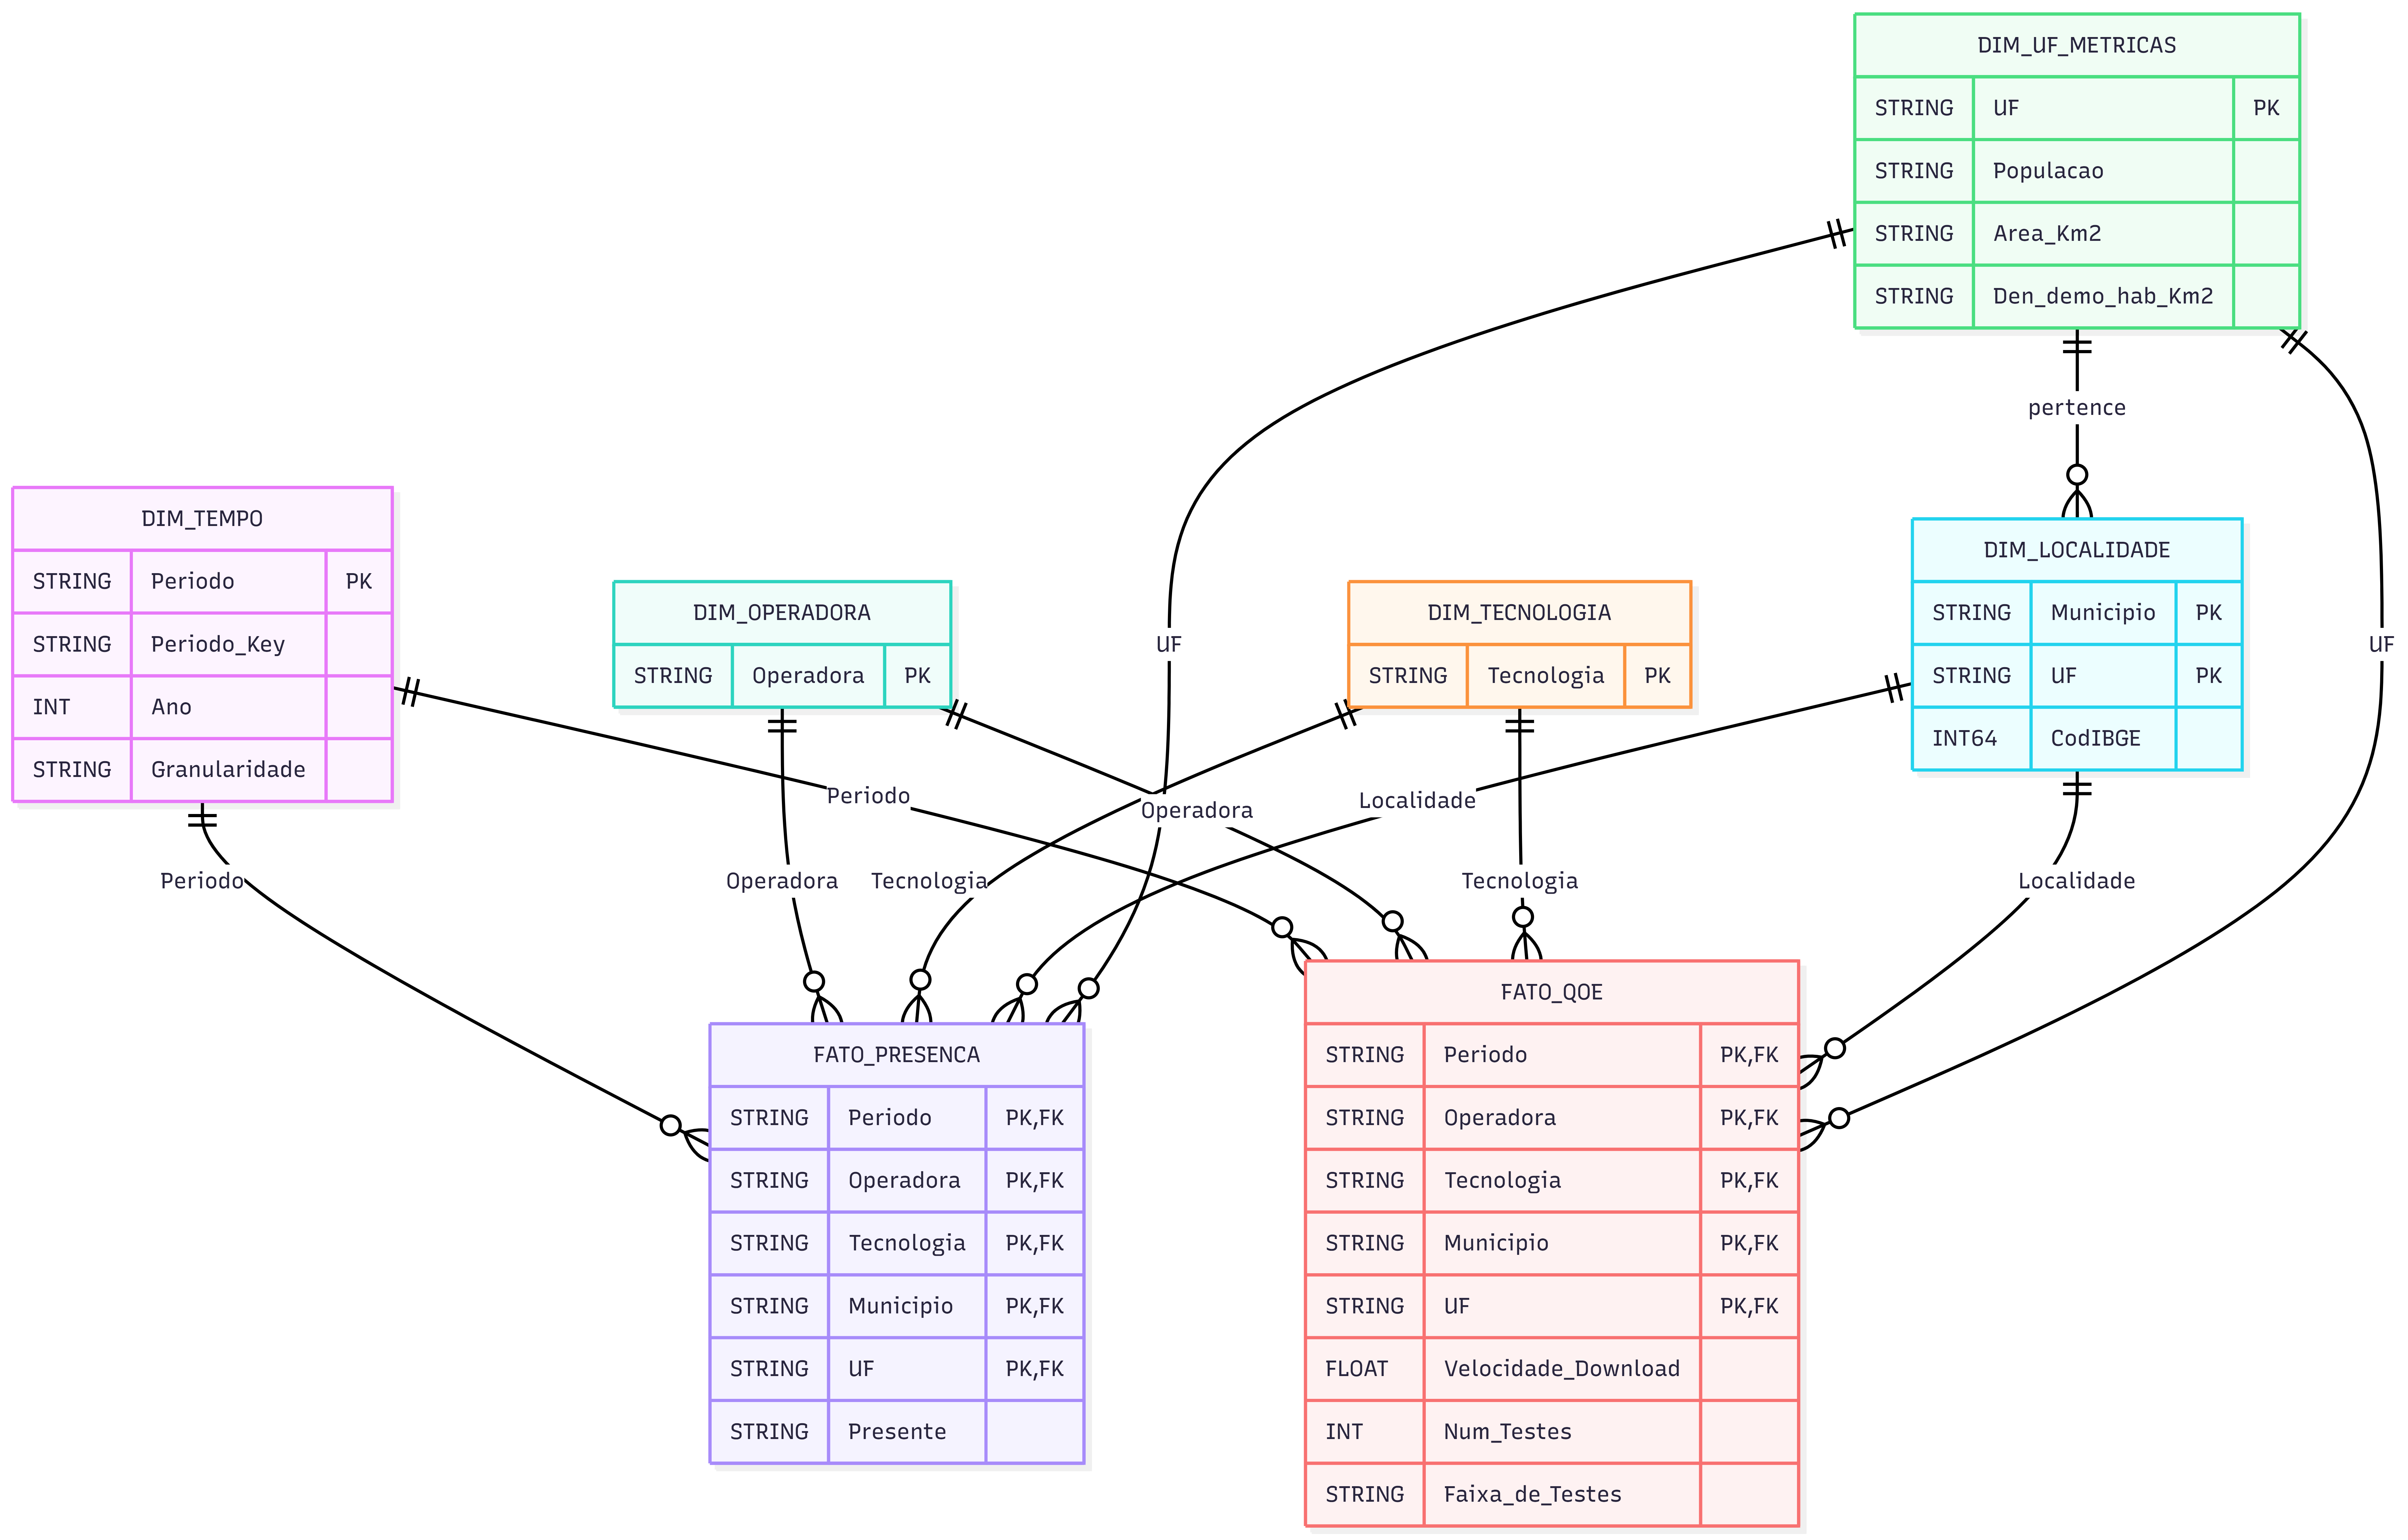

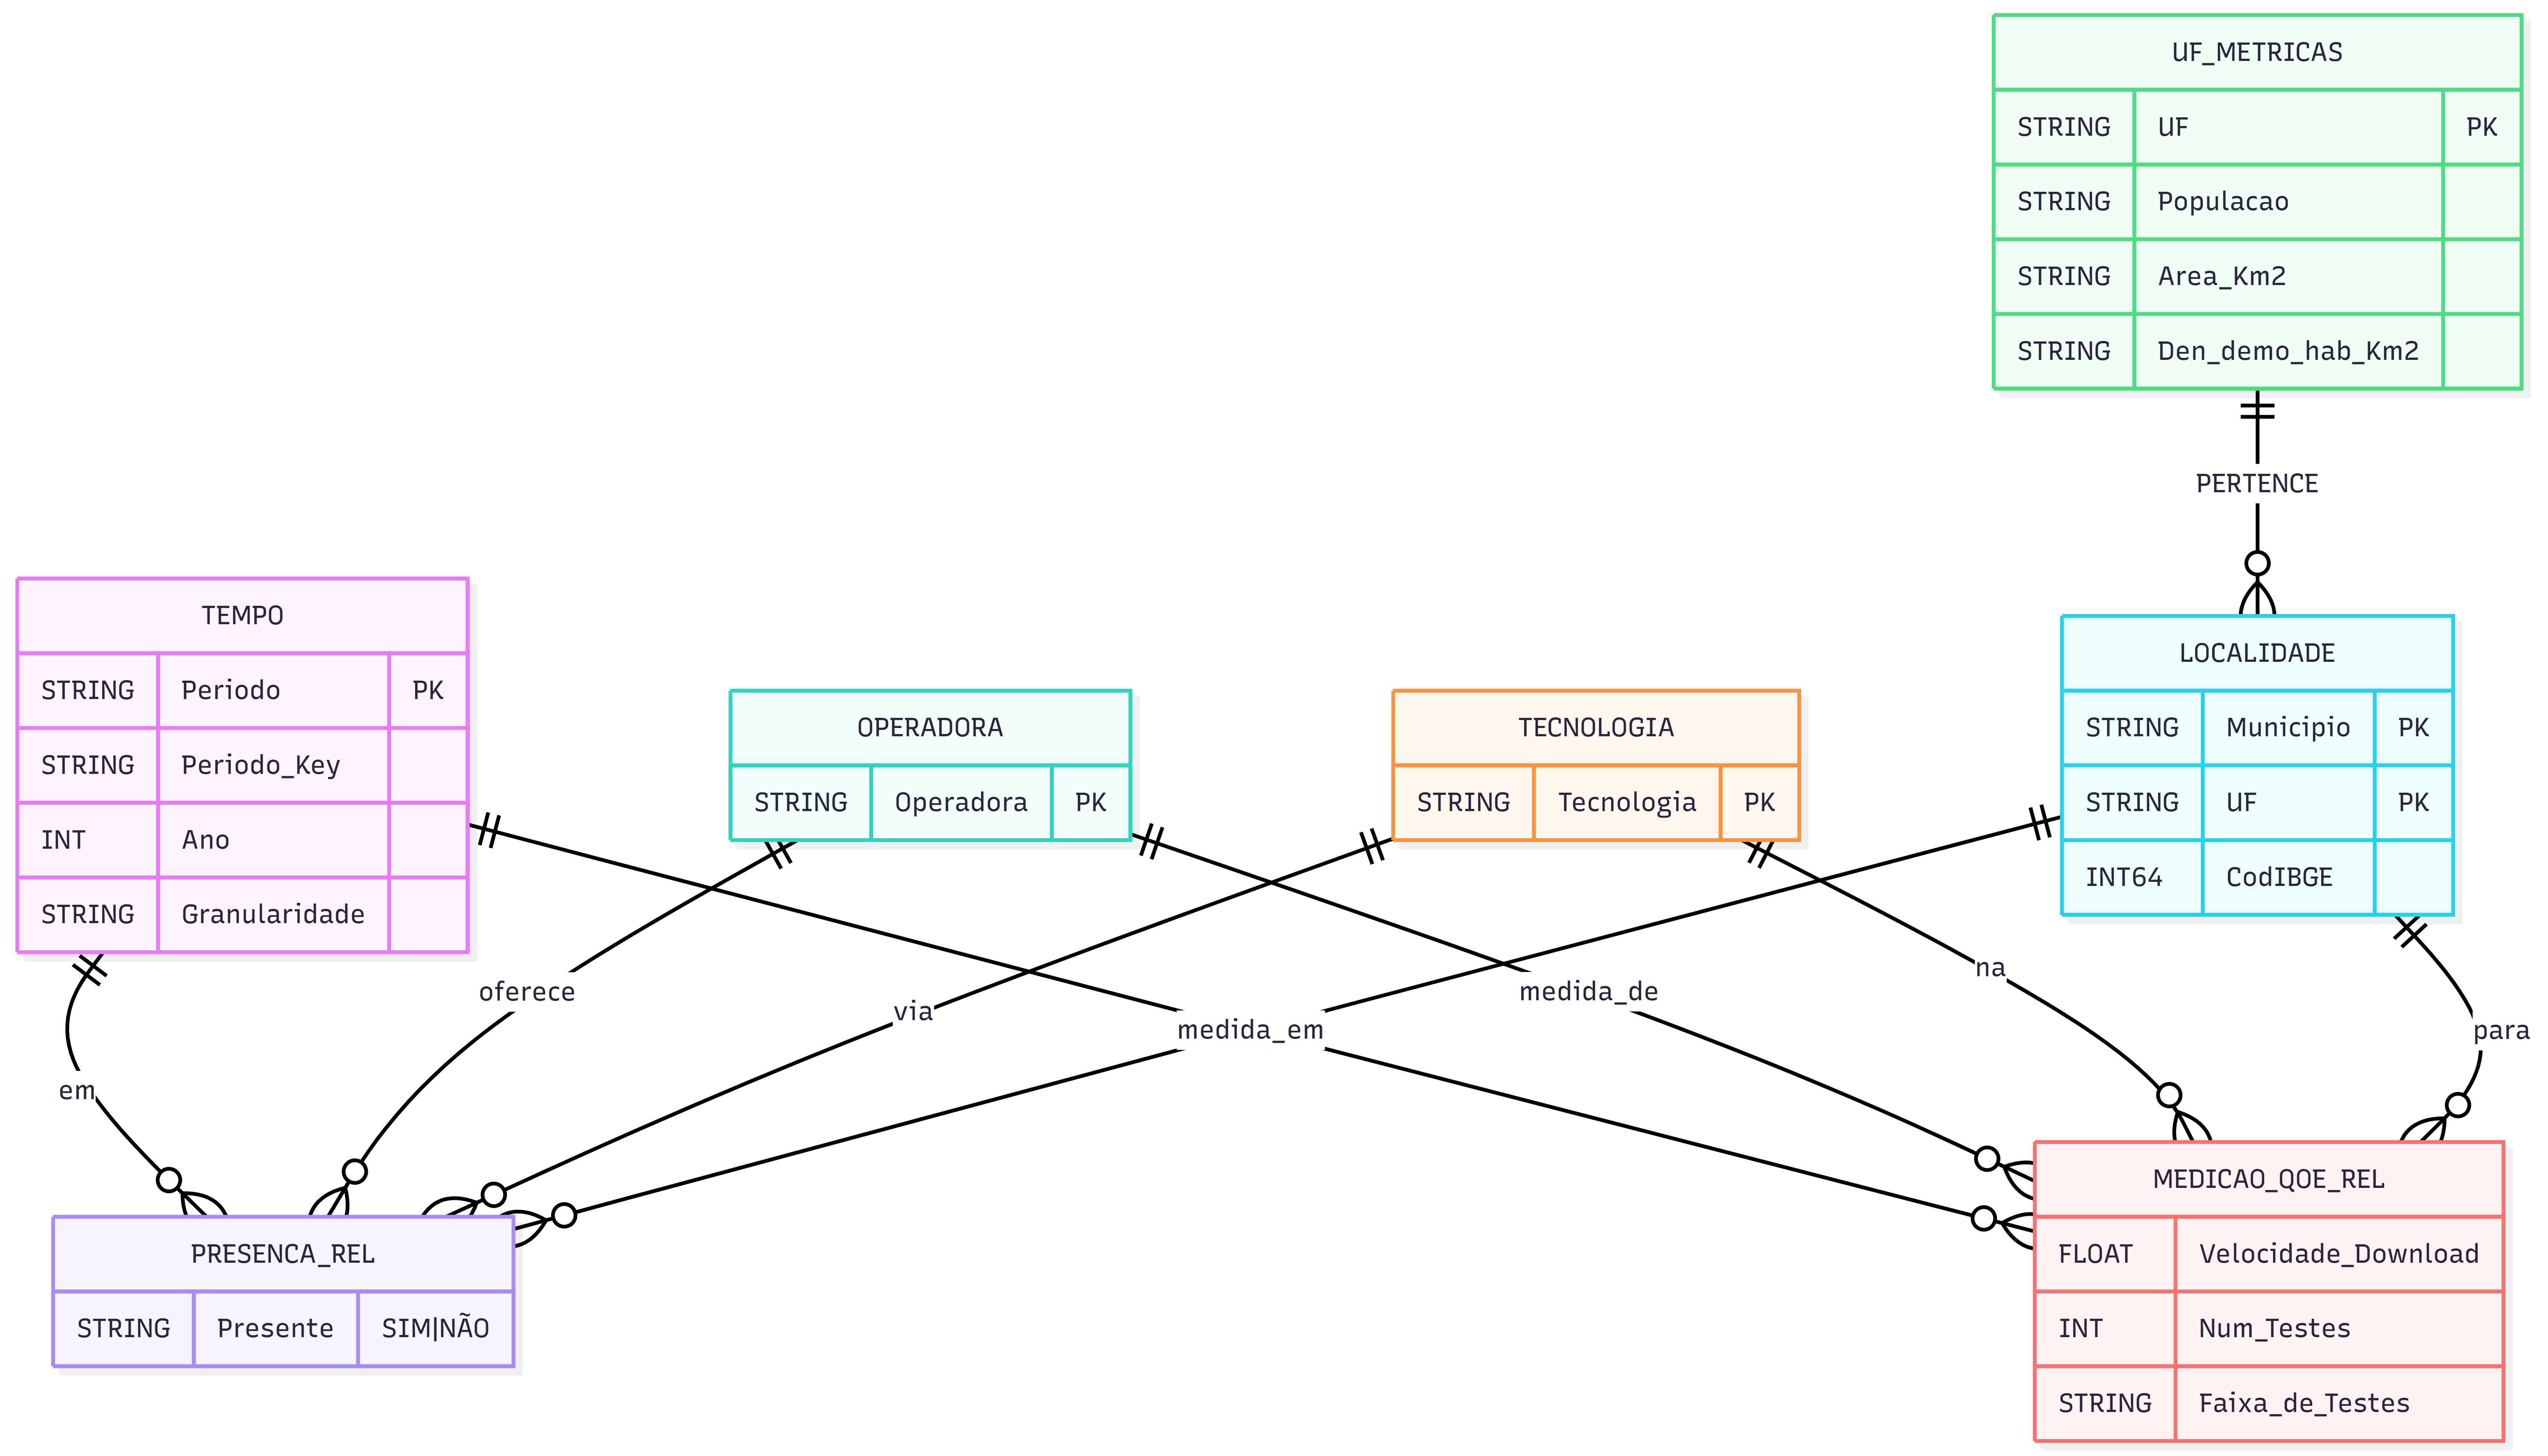

### 5.3 Scripts SQL (BigQuery) – criação do DW (dimensões + fatos)

-- Dataset: project-7aa7a54f-1f07-4513-ba9.telefonia_dw (nome do projeto criado)

-- Fonte: external tables já criadas

-- DIMENSÕES

--DIM_TEMPO (usando fn_parse_periodo)

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- DIM_TEMPO (usando fn_parse_periodo)

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tempo` AS
WITH all_periodos AS (
  SELECT DISTINCT Periodo FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`
  UNION DISTINCT
  SELECT DISTINCT Periodo FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`
),
parsed AS (

  SELECT
    Periodo,
    p.periodo_key AS Periodo_Key,
    p.ano AS Ano,
    p.granularidade AS Granularidade
  FROM all_periodos, UNNEST([`project-7aa7a54f-1f07-4513-ba9`.telefonia_dw.fn_parse_periodo(Periodo)]) p
)
SELECT * FROM parsed;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tempo`
ADD CONSTRAINT pk_dim_tempo PRIMARY KEY(Periodo) NOT ENFORCED;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- DIM_OPERADORA

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_operadora` AS
SELECT DISTINCT Operadora
FROM (
  SELECT Operadora FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`
  UNION DISTINCT
  SELECT Operadora FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`
);

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_operadora`
ADD CONSTRAINT pk_dim_operadora PRIMARY KEY(Operadora) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
--DIM_TECNOLOGIA

CREATE OR REPLACE T ABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tecnologia` AS
SELECT DISTINCT Tecnologia
FROM (
  SELECT Tecnologia FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`
  UNION DISTINCT
  SELECT Tecnologia FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`
);

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tecnologia`
ADD CONSTRAINT pk_dim_tecnologia PRIMARY KEY(Tecnologia) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- DIM_LOCALIDADE

-- PK composta: (Municipio, UF)
-- CodIBGE só existe na tabela de presença, então usamos MAX(CodIBGE)

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_localidade` AS
WITH locs AS (
  SELECT Municipio, UF, CodIBGE
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`
  UNION ALL
  SELECT Municipio, UF, CAST(NULL AS INT64) AS CodIBGE
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`
)
SELECT
  Municipio,
  UF,
  MAX(CodIBGE) AS CodIBGE
FROM locs
GROUP BY Municipio, UF;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_localidade`
ADD CONSTRAINT pk_dim_localidade PRIMARY KEY(Municipio, UF) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
--DIM_UF_METRICAS (somente linhas de UF)
Como brasil_regioes mistura Brasil, regiões e UFs, foi filtrado por padrão de UF (2 letras).

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_uf_metricas` AS
SELECT
  Regiao_UF AS UF,
  Populacao,
  Area_Km2,
  Den_demo_hab_Km2
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_brasil_regioes`
WHERE REGEXP_CONTAINS(Regiao_UF, r'^[A-Z]{2}$');

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_uf_metricas`
ADD CONSTRAINT pk_dim_uf_metricas PRIMARY KEY(UF) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- FATOS

-- FATO_PRESENCA -- (Periodo + Operadora + Tecnologia + Municipio + UF)

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca` AS
SELECT
  Periodo,
  Operadora,
  Tecnologia,
  Municipio,
  UF,
  Presente

  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
ADD CONSTRAINT pk_fato_presenca PRIMARY KEY(Periodo, Operadora, Tecnologia, Municipio, UF) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- FATO_QOE

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe` AS
SELECT
  Periodo,
  Operadora,
  Tecnologia,
  Municipio,
  UF,
  Velocidade_Download,
  Num_Testes,
  Faixa_de_Testes
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
ADD CONSTRAINT pk_fato_qoe PRIMARY KEY(Periodo, Operadora, Tecnologia, Municipio, UF) NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- FKs da FATO_PRESENCA

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
ADD FOREIGN KEY (Periodo)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tempo` (Periodo)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
ADD FOREIGN KEY (Operadora)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_operadora` (Operadora)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
ADD FOREIGN KEY (Tecnologia)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tecnologia` (Tecnologia)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
ADD FOREIGN KEY (Municipio, UF)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_localidade` (Municipio, UF)
NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- FKs da FATO_QOE

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
ADD FOREIGN KEY (Periodo)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tempo` (Periodo)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
ADD FOREIGN KEY (Operadora)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_operadora` (Operadora)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
ADD FOREIGN KEY (Tecnologia)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tecnologia` (Tecnologia)
NOT ENFORCED;

ALTER TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
ADD FOREIGN KEY (Municipio, UF)
REFERENCES `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_localidade` (Municipio, UF)
NOT ENFORCED;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Views para correlacionar Presença + QoE
-- View unificada para análise (QoE + Presença)

CREATE OR REPLACE VIEW `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.vw_qoe_com_presenca` AS
SELECT
  q.Periodo,
  q.Operadora,
  q.Tecnologia,
  q.UF,
  q.Municipio,
  p.Presente,
  q.Velocidade_Download,
  q.Num_Testes,
  q.Faixa_de_Testes
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe` q
LEFT JOIN `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca` p
USING (Periodo, Operadora, Tecnologia, UF, Municipio);

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

### 5.4 Detalahamento e Linhagem dos Dados

1. ANATEL - Tabela_Municipios_Atendidos
   • URL: https://dados.gov.br/dados/conjuntos-dados/infraestrutura---presenca-da-telefonia-movel---rqual
   • Técnica: Download CSV
   
2. IBGE - Dados demográficos
   • URL: https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html
   • Técnica: Download CSV
   
3. ANATEL - Dados_QoE_Consolidado
   • URL: https://dados.gov.br/dados/conjuntos-dados/qualidade-telefonia-movel
   • Técnica: Download CSV

### 5.5 Catálogo de Dados

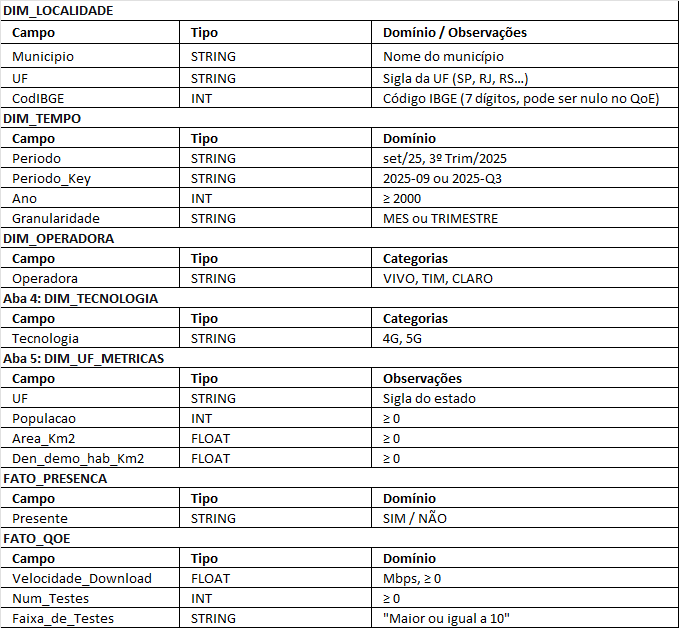

Técnica de composição:

Carregado os dados como external tables (CSV),

normalizado em staging (parse de período,

limpeza de números, mapeamento SIM/NÃO),

consolidado dimensões e fatos via SQL com

CREATE ... INSERT ... SELECT ... JOIN (Municipio/UF-CodIBGE).

## 6 Carga / ETL


Os dados foram extraídos a partir de arquivos CSV armazenados no Google Cloud Storage, sendo acessados no BigQuery por meio de External Tables.

Na etapa de transformação, foram aplicadas rotinas de normalização de dados categóricos, padronização de siglas de UF e operadoras,
conversão de campos numéricos originalmente armazenados como texto e deduplicação de registros com base no grão analítico definido.

O campo Período foi tratado por meio de uma função SQL específica, permitindo a padronização de granularidades mensais e trimestrais.

Após as transformações, os dados foram carregados em tabelas dimensionais e de fatos no Data Warehouse, seguindo a modelagem em Esquema Estrela.

Junção e conciliação:

QoE - Presença só concilia por Municipio+UF+Operadora+Tecnologia+Periodo

Se houver divergência de escrita do município (“Santo Ângelo” vs “Santo Angelo”), isso gera linhas “órfãs” — precisa regra de normalização
(ver Qualidade).

Deduplicação:

Em presença: pode ter múltiplas linhas iguais.
 Regra: manter 1 (ou priorizar SIM se houver conflito).

Padronização de categorias:
 Presente normalizar: SIM/NÃO

Tecnologia normalizar: 4G/5G

-- Scripts JÁ EXECUTADO
-- Mantido para documentação e reprodutibilidade

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
--Conversão numérica (em brasil_regioes): trocar separadores, remover pontos de milhar, converter para NUMERIC/FLOAT.

-- Curated” para UF métricas:
-- (curated)camada de dados tratados, limpos e padronizados, prontos para uso analítico

CREATE OR REPLACE TABLE `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.cur_uf_metricas` AS
SELECT
  Regiao_UF AS UF,
  SAFE_CAST(REGEXP_REPLACE(Populacao, r'\D', '') AS INT64) AS Populacao,
  SAFE_CAST(REPLACE(REPLACE(Area_Km2, '.', ''), ',', '.') AS FLOAT64) AS Area_Km2,
  SAFE_CAST(REPLACE(REPLACE(Den_demo_hab_Km2, '.', ''), ',', '.') AS FLOAT64) AS Den_demo_hab_Km2
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_brasil_regioes`
WHERE REGEXP_CONTAINS(Regiao_UF, r'^[A-Z]{2}$');
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Análise de Qualidade de Dados (por atributo) – checks + correções

-- Nulos e categorias inválidas (Presença):

SELECT
  COUNTIF(Periodo IS NULL) AS null_periodo,
  COUNTIF(Operadora IS NULL) AS null_operadora,
  COUNTIF(Municipio IS NULL) AS null_municipio,
  COUNTIF(UF IS NULL) AS null_uf,
  COUNTIF(Tecnologia IS NULL) AS null_tecnologia,
  COUNTIF(Presente IS NULL) AS null_presente,
  COUNTIF(Presente NOT IN ('SIM','NÃO')) AS inval_presente,
  COUNTIF(NOT REGEXP_CONTAINS(UF, r'^[A-Z]{2}$')) AS inval_uf
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- QoE: faixas, num_testes, velocidade e outliers:

SELECT
  COUNTIF(Velocidade_Download IS NULL) AS null_vel,
  COUNTIF(Velocidade_Download < 0) AS vel_negativa,
  COUNTIF(Velocidade_Download > 2000) AS vel_outlier,
  COUNTIF(Num_Testes IS NULL) AS null_testes,
  COUNTIF(Num_Testes < 0) AS testes_neg,
  COUNTIF(Num_Testes = 0) AS testes_zero,
  COUNTIF(Tecnologia NOT IN ('4G','5G')) AS tec_invalida
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Conciliação de localidades (município/UF) entre as duas fontes:

WITH a AS (
  SELECT DISTINCT Municipio, UF
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_municipios_atendidos`
),
b AS (
  SELECT DISTINCT Municipio, UF
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.ext_dados_qoe_consolidado`
)
SELECT
  (SELECT COUNT(*) FROM a) AS locs_presenca,
  (SELECT COUNT(*) FROM b) AS locs_qoe,
  (SELECT COUNT(*) FROM b LEFT JOIN a USING(Municipio,UF) WHERE a.Municipio IS NULL) AS qoe_sem_presenca,
  (SELECT COUNT(*) FROM a LEFT JOIN b USING(Municipio,UF) WHERE b.Municipio IS NULL) AS presenca_sem_qoe;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df


No projeto, a camada Bronze corresponde aos dados brutos disponibilizados em arquivos CSV no Google Cloud Storage e acessados por meio de tabelas externas no BigQuery.

A camada Silver (Curated) realiza a limpeza, padronização e transformação dos dados, garantindo consistência semântica.

Por fim, a camada Gold é composta pelo Data Warehouse modelado em esquema estrela, incluindo tabelas fato, dimensões e views analíticas, estando pronta para consumo por ferramentas de Business Intelligence e análises

BRONZE
└── CSVs no GCS

└── External Tables (BigQuery)


SILVER (CURATED)

└── Dados limpos, normalizados
   
    └── Funções e views de tratamento

GOLD
└── Data Warehouse (Esquema Estrela)

    ├── Dimensões
    ├── Fatos
    └── Views Analíticas

## 7 Cases utilizados

Ranking de UFs por cobertura 4G e 5G

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
-- Comparar maturidade de cobertura entre estados e tecnologias.

WITH mun_uf AS (
  SELECT
    UF,
    Municipio,
    MAX(IF(Tecnologia='4G' AND Presente='SIM', 1, 0)) AS cob_4g,
    MAX(IF(Tecnologia='5G' AND Presente='SIM', 1, 0)) AS cob_5g
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
  GROUP BY UF, Municipio
)
SELECT
  UF,
  SAFE_DIVIDE(SUM(cob_4g), COUNT(*)) AS perc_cobertura_4g,
  SAFE_DIVIDE(SUM(cob_5g), COUNT(*)) AS perc_cobertura_5g,
  COUNT(*) AS municipios_total
FROM mun_uf
GROUP BY UF
ORDER BY perc_cobertura_5g DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=27, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe: df
# uuid: 96587536-DD25-41A3-A6D7-DF6FEAEC3045
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df', uuid='96587536-DD25-41A3-A6D7-DF6FEAEC3045')

<IPython.core.display.Javascript object>

Observa-se significativa heterogeneidade na cobertura móvel entre as Unidades Federativas. Enquanto a tecnologia 4G apresenta ampla difusão, a cobertura 5G ainda se concentra em determinados estados, evidenciando desigualdade no processo de modernização da infraestrutura de telecomunicações.

Cobertura 4G e 5G por operadora (Brasil)

Quem investe mais em capilaridade.


In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH mun_oper AS (
  SELECT
    Operadora,
    Municipio,
    MAX(IF(Tecnologia='4G' AND Presente='SIM', 1, 0)) AS cob_4g,
    MAX(IF(Tecnologia='5G' AND Presente='SIM', 1, 0)) AS cob_5g
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
  GROUP BY Operadora, Municipio
)
SELECT
  Operadora,
  SAFE_DIVIDE(SUM(cob_4g), COUNT(*)) AS perc_cobertura_4g,
  SAFE_DIVIDE(SUM(cob_5g), COUNT(*)) AS perc_cobertura_5g,
  COUNT(*) AS municipios_total
FROM mun_oper
GROUP BY Operadora
ORDER BY perc_cobertura_5g DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=3, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe: df
# uuid: BD9EAF9F-FE53-47C4-97DD-B39ED63FC1BC
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df', uuid='BD9EAF9F-FE53-47C4-97DD-B39ED63FC1BC')

<IPython.core.display.Javascript object>

As operadoras apresentam estratégias distintas de cobertura. Enquanto o 4G já está amplamente disseminado entre todas, a expansão do 5G ocorre de forma desigual, indicando diferentes prioridades de investimento e estratégias competitivas.

Linha temporal — Municípios únicos cobertos (4G e 5G)

Evolução histórica da cobertura.

Foi considerado 2023 e 2024

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  t.Periodo_Key,
  COUNT(DISTINCT IF(p.Tecnologia='4G' AND p.Presente='SIM',
    CONCAT(p.UF,'|',p.Municipio), NULL)) AS municipios_4g,
  COUNT(DISTINCT IF(p.Tecnologia='5G' AND p.Presente='SIM',
    CONCAT(p.UF,'|',p.Municipio), NULL)) AS municipios_5g
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca` p
JOIN `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.dim_tempo` t
ON p.Periodo = t.Periodo
GROUP BY t.Periodo_Key
ORDER BY t.Periodo_Key;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=25, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe: df
# uuid: 00AC61AD-2144-4B60-AA54-CB146CBEF18C
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df', uuid='00AC61AD-2144-4B60-AA54-CB146CBEF18C')

<IPython.core.display.Javascript object>

A análise temporal evidencia crescimento contínuo da cobertura 4G ao longo dos anos, enquanto o 5G apresenta expansão mais recente e acelerada, refletindo a introdução progressiva da nova tecnologia no país.

QoE — Média de download por operadora e tecnologia

Quem entrega melhor qualidade.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  Operadora,
  Tecnologia,
  AVG(Velocidade_Download) AS media_download_mbps,
  APPROX_QUANTILES(Velocidade_Download, 4)[OFFSET(2)] AS mediana_download_mbps,
  SUM(Num_Testes) AS total_testes
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
GROUP BY Operadora, Tecnologia
ORDER BY media_download_mbps DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=6, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe: df
# uuid: 85E36B10-3005-418E-BC4D-530252739A6B
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df', uuid='85E36B10-3005-418E-BC4D-530252739A6B')

<IPython.core.display.Javascript object>

Os resultados indicam diferenças relevantes na qualidade de experiência entregue pelas operadoras. A tecnologia 5G apresenta velocidades médias superiores ao 4G, embora com menor volume de medições, o que deve ser considerado na interpretação dos resultados.

Dispersão — QoE × Total de Testes
Velocidade × confiabilidade estatística.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  Operadora,
  Tecnologia,
  AVG(Velocidade_Download) AS media_download_mbps,
  SUM(Num_Testes) AS total_testes
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_qoe`
GROUP BY Operadora, Tecnologia;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=6, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe:
# uuid: ACE1CAA8-CD27-4ED5-91BD-C9F0AC14EA16
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='', uuid='ACE1CAA8-CD27-4ED5-91BD-C9F0AC14EA16')

Demonstra que altas velocidades médias nem sempre estão associadas a grandes volumes de testes, reforçando a necessidade de analisar conjuntamente desempenho e confiabilidade das medições.

Quantidade de 4G e 5G no Rio de Jaeiro e onde tem maior quantidade

Municípios com menor presença 5G por operadora (Top 10)


Em quais municípios a cobertura 5G é inexistente ou mínima e quais operadoras estão (ou não) presentes?

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH presenca_5g AS (
  SELECT
    UF,
    Municipio,
    Operadora,
    MAX(IF(Presente='SIM', 1, 0)) AS possui_5g
  FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.fato_presenca`
  WHERE Tecnologia = '5G'
  GROUP BY UF, Municipio, Operadora
),

resumo_municipio AS (
  SELECT
    UF,
    Municipio,
    SUM(possui_5g) AS qtd_operadoras_5g
  FROM presenca_5g
  GROUP BY UF, Municipio
),

top10_piores AS (
  SELECT
    UF,
    Municipio,
    qtd_operadoras_5g
  FROM resumo_municipio
  ORDER BY qtd_operadoras_5g ASC, UF, Municipio
  LIMIT 10
)

SELECT
  p.UF,
  p.Municipio,
  p.Operadora,
  p.possui_5g
FROM presenca_5g p
JOIN top10_piores t
  ON p.UF = t.UF
 AND p.Municipio = t.Municipio
ORDER BY p.UF, p.Municipio, p.possui_5g ASC, p.Operadora;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

A análise dos municípios com menor presença de tecnologia 5G evidencia localidades nas quais nenhuma ou apenas uma operadora disponibiliza a nova geração de rede móvel.

Ao detalhar a presença por operadora, observa-se que a ausência de 5G não é homogênea entre as empresas, indicando estratégias distintas de expansão e reforçando a existência de lacunas territoriais relevantes no acesso à tecnologia.

Top 10 UFs com MENOR cobertura 5G (foco em desigualdade)

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """

SELECT
  UF,
  perc_cobertura_5g,
  municipios_total,
  municipios_cobertos_5g
FROM `project-7aa7a54f-1f07-4513-ba9.telefonia_dw.vw_cobertura_5g_uf`
ORDER BY perc_cobertura_5g ASC
LIMIT 10;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=10, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# dataframe: df
# uuid: FDD420C5-F643-4596-89CD-F4D65A81DA61
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='df', uuid='FDD420C5-F643-4596-89CD-F4D65A81DA61')

<IPython.core.display.Javascript object>

## 8 Conclusão

Este trabalho apresentou a construção de um Data Warehouse multidimensional para análise da presença da telefonia móvel 4G e 5G nos municípios brasileiros, integrando dados de cobertura e Qualidade de Experiência (QoE) em uma arquitetura moderna baseada em nuvem. O projeto foi implementado utilizando o Google Cloud Platform, com dados armazenados no Google Cloud Storage e processados no BigQuery, garantindo escalabilidade, reprodutibilidade e rastreabilidade de todo o pipeline.

A modelagem dos dados seguiu o esquema estrela, com duas tabelas fato complementares — uma voltada à presença da infraestrutura e outra às métricas de QoE — e dimensões compartilhadas de tempo, operadora, tecnologia e localidade, além de uma dimensão de métricas por Unidade Federativa. O uso exclusivo de chaves naturais assegurou aderência às restrições do projeto e transparência semântica na representação dos dados.

O pipeline de dados foi estruturado segundo o paradigma Bronze–Silver–Gold, no qual a camada Bronze preserva os dados brutos oriundos das fontes originais, a camada Silver (Curated) realiza a limpeza, padronização e consolidação das informações, e a camada Gold disponibiliza os dados modelados e prontos para análise. Essa abordagem garantiu consistência entre as fontes, mitigou problemas de qualidade e possibilitou análises confiáveis.

As análises realizadas evidenciaram desigualdades regionais na cobertura 5G, diferenças estratégicas entre operadoras e uma expansão gradual da nova tecnologia ao longo do tempo. A integração entre cobertura e QoE permitiu avaliar não apenas onde a tecnologia está disponível, mas também a qualidade efetivamente entregue aos usuários, destacando a importância de considerar volume de testes e contexto regional na interpretação dos resultados.

Por fim, o projeto demonstra como técnicas de engenharia de dados, modelagem dimensional e análise analítica podem ser aplicadas de forma integrada para apoiar a compreensão do cenário de telecomunicações no Brasil. Como trabalhos futuros, sugere-se a incorporação de novas métricas de QoE, dados socioeconômicos adicionais e análises preditivas, ampliando o potencial do Data Warehouse como ferramenta de suporte à tomada de decisão e à formulação de políticas públicas.